In [18]:
#!/usr/bin/env python

# Copyright 2016, Rohan Dandage <rraadd_8@hotmail.com>
# This program is distributed under General Public License v. 3.    

import sys
import os
from os.path import exists,splitext,basename
import glob
import nd2reader
import pandas as pd
import string
import numpy as np
from scipy import stats,ndimage
from multiprocessing import Pool
import cv2
from skimage.segmentation import random_walker
# from skimage.data import binary_blobs
from skimage import io,exposure,restoration,filters,morphology,measure
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import subprocess

In [19]:
def nd2arr_list(nd_dh,nd_fns):
    arr_list=[]
    for nd_fn in nd_fns:
        nd = nd2reader.Nd2("%s/%s" % (nd_dh,nd_fn))
        for ndi in nd:
            arr_list.append(np.array(ndi))
        del nd
    return arr_list

def raw2phasecorr(arr_list): #cv
    cx = 0.0
    cy = 0.0
    stb_arr_list=[]
    prev_frame = arr_list[0]
    prev_image = np.float32(restoration.denoise_tv_chambolle(prev_frame.astype('uint16'), weight=0.1, multichannel=True)) #ref
    for frame in arr_list:           
        image = np.float32(restoration.denoise_tv_chambolle(frame.astype('uint16'), weight=0.1, multichannel=True))
        # TODO: set window around phase correlation
        dp = cv2.phaseCorrelate(prev_image, image)
        cx = cx - dp[0]
        cy = cy - dp[1]
        xform = np.float32([[1, 0, cx], [0, 1, cy]])
        stable_image = cv2.warpAffine(frame.astype('float32'), xform, dsize=(image.shape[1], image.shape[0]))
        prev_image = image
        #clip sides
        ht,wd=np.shape(stable_image)
        clip=0.125 #0.25
        lt=int(wd*clip)
        rt=int(wd-wd*clip)
        up=int(ht*clip)
        dw=int(ht-ht*clip)
        stable_image_clipped=stable_image[up:dw,lt:rt]
        stb_arr_list.append(stable_image_clipped)
    return stb_arr_list

def arr_list2regions(arr_list, time_increment):
    pre_bleach=arr_list_stb[0]
    smoothened = filters.median(pre_bleach.astype('uint16'),np.ones((4,4)))
    markers = np.zeros(smoothened.shape, dtype=np.uint)
    markers[smoothened < filters.threshold_otsu(smoothened)] = 1
    markers[smoothened > filters.threshold_otsu(smoothened)] = 2
    labels = random_walker(smoothened, markers, beta=10, mode='bf')
    regions= measure.label(labels)
    label_objects, nb_labels = ndimage.label(regions)
    sizes = np.bincount(label_objects.ravel())
    mask_sizes = ((sizes > 200) & (sizes < 5000))
    mask_sizes[0] = 0
    regions_cleaned = mask_sizes[label_objects]
    props = measure.regionprops(regions,arr_list[0]) #ref
    regions_areas=np.array([prop.area for prop in props])
    regions_index_large=np.where((regions_areas<5000) & (regions_areas>200))[0]
    kins_mean=pd.DataFrame(columns=regions_index_large, index=range(len(arr_list)))
    for i in range(len(arr_list)):
        props = measure.regionprops(regions,arr_list[i])
        means=np.array([prop.mean_intensity for prop in props])
        kins_mean.loc[i,:]=means[regions_index_large]
        del props
    kins_mean=kins_mean.loc[:, ~(kins_mean < 2000).any(axis=0)] #stitch
    kins_mean['time']=np.array(range(len(arr_list)))*time_increment #stitch
    return regions_cleaned,kins_mean

def arr_list2vid(arr_list,regions,kins_mean,vid_fh,xpixels, ypixels):
    dpi = 100
    png_dh=os.path.splitext(vid_fh)[0]
    if not os.path.exists(png_dh):
        try:
            os.makedirs(png_dh)
        except :
            print ">>> WARNING : race error data_lbl"
    fig = plt.figure(figsize=(ypixels/dpi*2, xpixels/dpi), dpi=dpi)
    ax_img = plt.subplot(1,2,1)
    ax_kin = plt.subplot(1,2,2)
    ax_img.set_axis_off()
    ax_img.set_aspect('equal')
    for i in range(len(arr_list)):
        ax_img.imshow(arr_list[i],cmap='gray',animated=True)
        ax_img.contour(regions, [0.5], linewidths=1.2, colors='r',animated=False)
        if len(kins_mean.columns)>1:
            kins_mean.plot(x='time',legend=False,ax=ax_kin)
            ax_kin.plot(kins_mean['time'],kins_mean.drop(['time'], axis=1).mean(axis=1),lw=6,color='k')
        ax_kin.set_xlim([kins_mean.loc[0,'time'],kins_mean.loc[len(kins_mean)-1,'time']])
        ax_kin.axvline(kins_mean.loc[i,'time'], color='r', linestyle='--',lw=2)
        plt.savefig(png_dh+'/%02d.png' % i)
        ax_kin.clear()
    bash_command=("ffmpeg -f image2 -r 4 -i "+png_dh+"/%02d.png -vcodec mpeg4 -y "+vid_fh)
    subprocess.Popen(bash_command, shell=True, executable='/bin/bash')


In [20]:
fh_xls='/home/kclabws1/Documents/propro/writ/prjs/2_chem_chap_screens/data/yeast_gfp_half_life/data/160309_sdsd_replicates/160309_sdsd_replicates.xlsx'
well='A16'

In [21]:
info=pd.read_excel(fh_xls,'info')
info=info.set_index('varname')
for var in info.iterrows() :
    val=info['input'][var[0]]
    if not pd.isnull(val):
        exec("%s=info['input']['%s']" % (var[0],var[0]),locals(), globals())
    else:
        exec("%s=info['default']['%s']" % (var[0],var[0]),locals(), globals())

data_job=pd.read_excel(fh_xls,'JobView')
data_fns=pd.pivot_table(data_job,values='File Name',index='Loop_bleach Index',columns='Well Name', aggfunc=lambda x: x.iloc[0])
data_fns_P =pd.pivot_table(data_job,values='File Name',index='TimeLapse1 Index',columns='Well Name', aggfunc=lambda x: x.iloc[0])
data_fns   =pd.concat([data_fns,data_fns_P],axis=0)

wells=[str(x) for x in list(data_job['Well Name'].unique())]
if not any(x in well for x in wells):
    print >> sys.stderr, "### ERROR : Could not find '%s'!" % well
    sys.exit(1)

In [22]:
if not exists("%s.%sstb.mp4" % (fh_xls,well)):
    print ">>> STATUS  : nd2vid : %s" % well 
    nd_fns=data_fns[well].dropna().unique()
    arr_list=nd2arr_list(nd_dh,nd_fns)
    arr_list_stb=raw2phasecorr(arr_list)
    regions,kins_mean=arr_list2regions(arr_list_stb,3)
#     arr_list2vid(arr_list_stb,regions,kins_mean,('%s.%sstb.mp4' % (fh_xls,well)),384, 384)
#     arr_list2vid(regions,arr_list    ,('%s.%sraw.mp4' % (fh_xls,well)),384, 384)
else:
    print ">>> STATUS  : nd2vid :already done"

>>> STATUS  : nd2vid : A16


In [75]:
del kins_mean

In [143]:
len(kins_mean.columns)
# len(arr_list)

1

In [6]:
nd_fns=data_fns[well].dropna().unique()
arr_list=nd2arr_list(nd_dh,nd_fns)


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


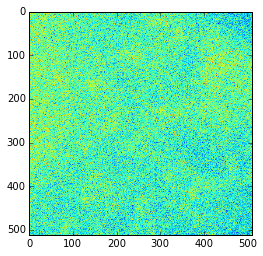

In [7]:
%pylab inline
plt.imshow(arr_list[0])


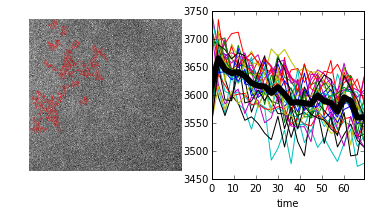

In [41]:
dpi=100
xpixels=384
ypixels=384
fig = plt.figure(figsize=(ypixels/dpi*2, xpixels/dpi), dpi=dpi)
ax_img = plt.subplot(1,2,1)
ax_kin = plt.subplot(1,2,2)
ax_img.set_axis_off()
ax_img.set_aspect('equal')
for i in [0]:#range(len(arr_list)):
    ax_img.imshow(arr_list[i],cmap='gray',animated=True)
    ax_img.contour(regions, [0.5], linewidths=0.25, colors='r',animated=False)
    if len(kins_mean.columns)>1:
        kins_mean.plot(x='time',legend=False,ax=ax_kin)
#         kins_mean.mean(axis=1).plot(legend=False,lw=6,ax=ax_kin)
        ax_kin.plot(kins_mean['time'],kins_mean.drop(['time'], axis=1).mean(axis=1),lw=6,color='k')
    ax_kin.set_xlim([kins_mean.loc[0,'time'],kins_mean.loc[len(kins_mean)-1,'time']])
    ax_kin.axvline(kins_mean.loc[i,'time'], color='r', linestyle='--',lw=2)
ax_img.set_aspect('equal')
plt.savefig('test.png')
# ax_kin.clear()

,5,170,207,222,337,451,454,459,537,563,...,1470,1477,1537,1559,1598,1710,1989,2102,2157,time
0,3581.529,3573.214,3715.512,3665.886,3746.313,3588.702,3695.658,3598.306,3719.635,3585.462,...,3596.605,3583.535,3593.631,3579.928,3557.331,3739.59,3715.455,3553.787,3549.189,0
1,3680.527,3699.132,3676.919,3609.434,3683.523,3676.998,3693.533,3640.681,3657.246,3711.593,...,3688.589,3690.164,3662.642,3654.393,3636.736,3679.178,3618.374,3615.523,3652.7,3
2,3673.059,3702.384,3691.679,3566.74,3671.39,3648.381,3629.335,3669.414,3669.682,3692.413,...,3656.966,3681.641,3650.734,3696.761,3617.727,3638.065,3583.944,3574.667,3591.438,6
3,3665.479,3629.767,3646.431,3637.945,3675.824,3672.217,3592.215,3633.7,3634.9,3710.208,...,3643.179,3665.176,3642.678,3636.85,3598.372,3636.501,3600.657,3607.653,3589.885,9
4,3649.265,3689.104,3655.114,3583.856,3669.677,3620.31,3641.27,3683.347,3631.718,3712.66,...,3637.911,3675.763,3624.562,3642.986,3601.685,3643.274,3610.665,3583.969,3664.764,12
5,3659.743,3652.425,3659.687,3573.775,3666.544,3658.363,3628.551,3619.923,3664.554,3665.019,...,3651.587,3670.522,3646.592,3637.597,3603.141,3630.987,3566.88,3598.985,3586.042,15
6,3644.085,3644.921,3637.636,3538.918,3661.329,3678.636,3569.574,3617.674,3606.729,3674.895,...,3635.546,3606.008,3598.638,3640.296,3583.023,3610.973,3596.767,3621.85,3589.355,18
7,3628.572,3635.173,3661.21,3582.233,3672.332,3654.652,3601.688,3623.515,3581.162,3658.02,...,3637.548,3640.754,3608.294,3621.979,3584.925,3602.223,3590.259,3577.19,3609.17,21
8,3659.773,3611.391,3612.105,3577.365,3636.516,3637.886,3608.184,3648.176,3603.025,3644.498,...,3630.899,3670.504,3605.447,3603.382,3575.383,3651.168,3550.362,3608.96,3590.295,24
9,3605.65,3619.91,3649.536,3483.612,3644.41,3598.35,3589.417,3599.756,3613.801,3643.042,...,3613.452,3600.16,3601.431,3589.004,3574.069,3617.206,3559.202,3569.067,3611.327,27


In [185]:
#random walker
pre_bleach=arr_list_stb[0]
smoothened = filters.median(pre_bleach.astype('uint16'),np.ones((4,4)))
markers = np.zeros(smoothened.shape, dtype=np.uint)
markers[smoothened < filters.threshold_otsu(smoothened)] = 1
markers[smoothened > filters.threshold_otsu(smoothened)] = 2
labels = random_walker(smoothened, markers, beta=10, mode='bf')
regions= measure.label(labels)
# plt.imshow(regions,cmap='jet')
label_objects, nb_labels = ndi.label(regions)
sizes = np.bincount(label_objects.ravel())
mask_sizes = sizes > 100
mask_sizes[0] = 0
regions_cleaned = mask_sizes[label_objects]

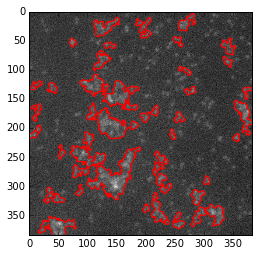

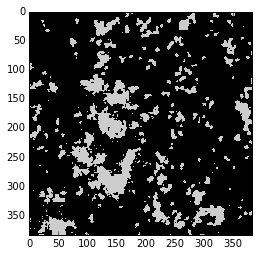

In [126]:
#watershed
from skimage.filters import sobel
from skimage import img_as_float
# pre_bleach_float = img_as_float(pre_bleach.astype('float64'))
image=pre_bleach.astype('float64')
elevation_map = sobel(image)
smoothened = filters.median(pre_bleach.astype('uint16'),np.ones((4,4)))
markers = np.zeros_like(image)
markers[smoothened < filters.threshold_otsu(smoothened)] = 1
markers[smoothened > filters.threshold_otsu(smoothened)] = 2
segmentation = morphology.watershed(elevation_map, markers)
plt.imshow(segmentation, cmap=plt.cm.spectral, interpolation='nearest')

In [112]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


ValueError: Images of type float must be between -1 and 1.

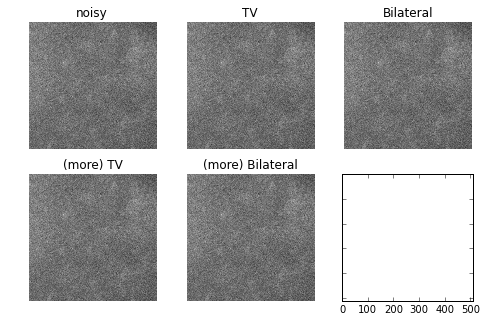

In [13]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data, img_as_float,filters
from skimage.restoration import denoise_tv_chambolle, denoise_bilateral


# astro = img_as_float(data.astronaut())
# astro = astro[220:300, 220:320]
image=arr_list[0]
# astro = image
astro = image.astype('uint16')
# astro = img_as_float(image.astype('uint16'))
# noisy = astro + 0.6 * astro.std() * np.random.random(astro.shape)
# noisy = np.clip(noisy, 0, 1)
noisy = astro
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(8, 5), sharex=True, sharey=True, subplot_kw={'adjustable':'box-forced'})

plt.gray()

ax[0, 0].imshow(noisy)
ax[0, 0].axis('off')
ax[0, 0].set_title('noisy')
ax[0, 1].imshow(denoise_tv_chambolle(noisy, weight=0.1, multichannel=True))
ax[0, 1].axis('off')
ax[0, 1].set_title('TV')
ax[0, 2].imshow(denoise_bilateral(noisy, sigma_range=0.05, sigma_spatial=15))
ax[0, 2].axis('off')
ax[0, 2].set_title('Bilateral')

ax[1, 0].imshow(denoise_tv_chambolle(noisy, weight=0.2, multichannel=True))
ax[1, 0].axis('off')
ax[1, 0].set_title('(more) TV')
ax[1, 1].imshow(denoise_bilateral(noisy, sigma_range=0.1, sigma_spatial=15))
ax[1, 1].axis('off')
ax[1, 1].set_title('(more) Bilateral')
ax[1, 2].imshow(filters.median(noisy,np.ones((4,4))))
ax[1, 2].axis('off')
ax[1, 2].set_title('median')

fig.subplots_adjust(wspace=0.02, hspace=0.2,
                    top=0.9, bottom=0.05, left=0, right=1)

plt.show()